In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from typing import List
import glob
import os
import gzip
from tqdm import tqdm
import seaborn as sns
import natsort
import hashlib
import random


In [2]:
df = pd.read_csv(r"C:\PhD\experiments\streaks_df.csv")

In [3]:
angles = [30, 45, 60, 90]
proximity_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05]
streak_length_thresholds = [20, 30, 40]

In [4]:
df

,file_path,angle,proximity_threshold,streak_length_threshold,streak_lengths,number_of_streaks
0,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,20,[],0
1,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,30,[],0
2,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,40,[],0
3,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.02,20,[93 25 27 22 48 21],6
4,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.02,30,[93 48],2
...,...,...,...,...,...,...
5515,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.04,30,[ 60 38 149 117 40 36 31 33 48 87 86 ...,103
5516,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.04,40,[ 60 149 117 40 48 87 86 62 88 44 60 1...,80
5517,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.05,20,[ 41 37 64 60 188 164 55 51 63 27 41 ...,214
5518,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.05,30,[ 41 37 64 60 188 164 55 51 63 41 31 ...,168


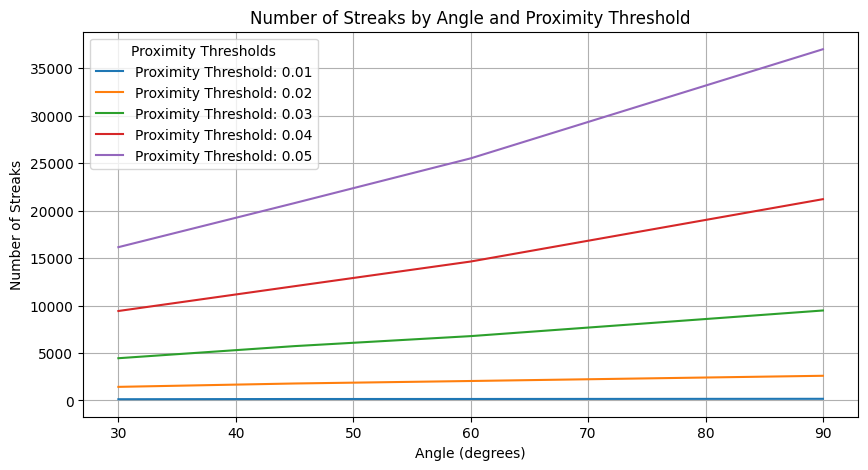

In [5]:
plt.figure(figsize=(10,5))

# Iterate over each proximity threshold to create separate lines on the plot
for proximity_threshold in proximity_thresholds:
    # Initialize a list to store the number of streaks for each angle
    num_streaks_list = []

    # Iterate over each angle
    for angle in angles:
        # Filter the DataFrame for the current angle and proximity threshold
        filtered_df = df[(df['angle'] == angle) & (df['proximity_threshold'] == proximity_threshold)]
        
        # Sum the number of streaks for the filtered DataFrame
        total_num_streaks = filtered_df['number_of_streaks'].sum()
        
        # Append the calculated value to the list
        num_streaks_list.append(total_num_streaks)

    # Plot the number of streaks for the current proximity threshold
    plt.plot(angles, num_streaks_list, label=f'Proximity Threshold: {proximity_threshold}')

# Add labels and title to the plot
plt.xlabel('Angle (degrees)')
plt.ylabel('Number of Streaks')
plt.title('Number of Streaks by Angle and Proximity Threshold')
plt.legend(title='Proximity Thresholds')
plt.grid(True)

# Show the plot
plt.show()

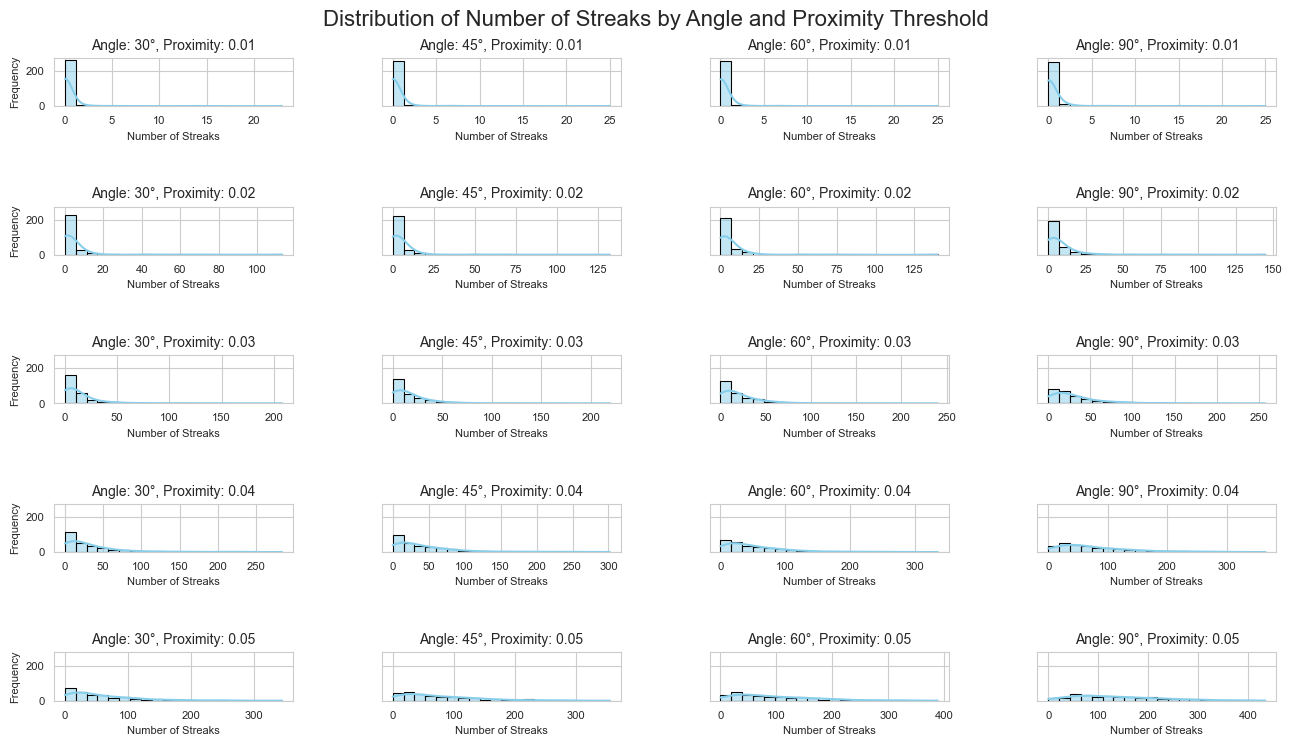

In [6]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(len(proximity_thresholds), len(angles), figsize=(14, 8), sharey=True)

fig.tight_layout(pad=5.0)
fig.subplots_adjust(top=0.92)

fig.suptitle('Distribution of Number of Streaks by Angle and Proximity Threshold', fontsize=16)

for i, proximity_threshold in enumerate(proximity_thresholds):
    for j, angle in enumerate(angles):
        filtered_df = df[(df['angle'] == angle) & (df['proximity_threshold'] == proximity_threshold)]
        
        sns.histplot(filtered_df['number_of_streaks'], bins=20, edgecolor='black', color='skyblue', ax=axes[i, j], kde=True)
        axes[i, j].set_title(f'Angle: {angle}°, Proximity: {proximity_threshold}', fontsize=10)
        axes[i, j].set_xlabel('Number of Streaks', fontsize=8)
        axes[i, j].set_ylabel('Frequency', fontsize=8)
        axes[i, j].tick_params(axis='both', which='major', labelsize=8)

plt.show()

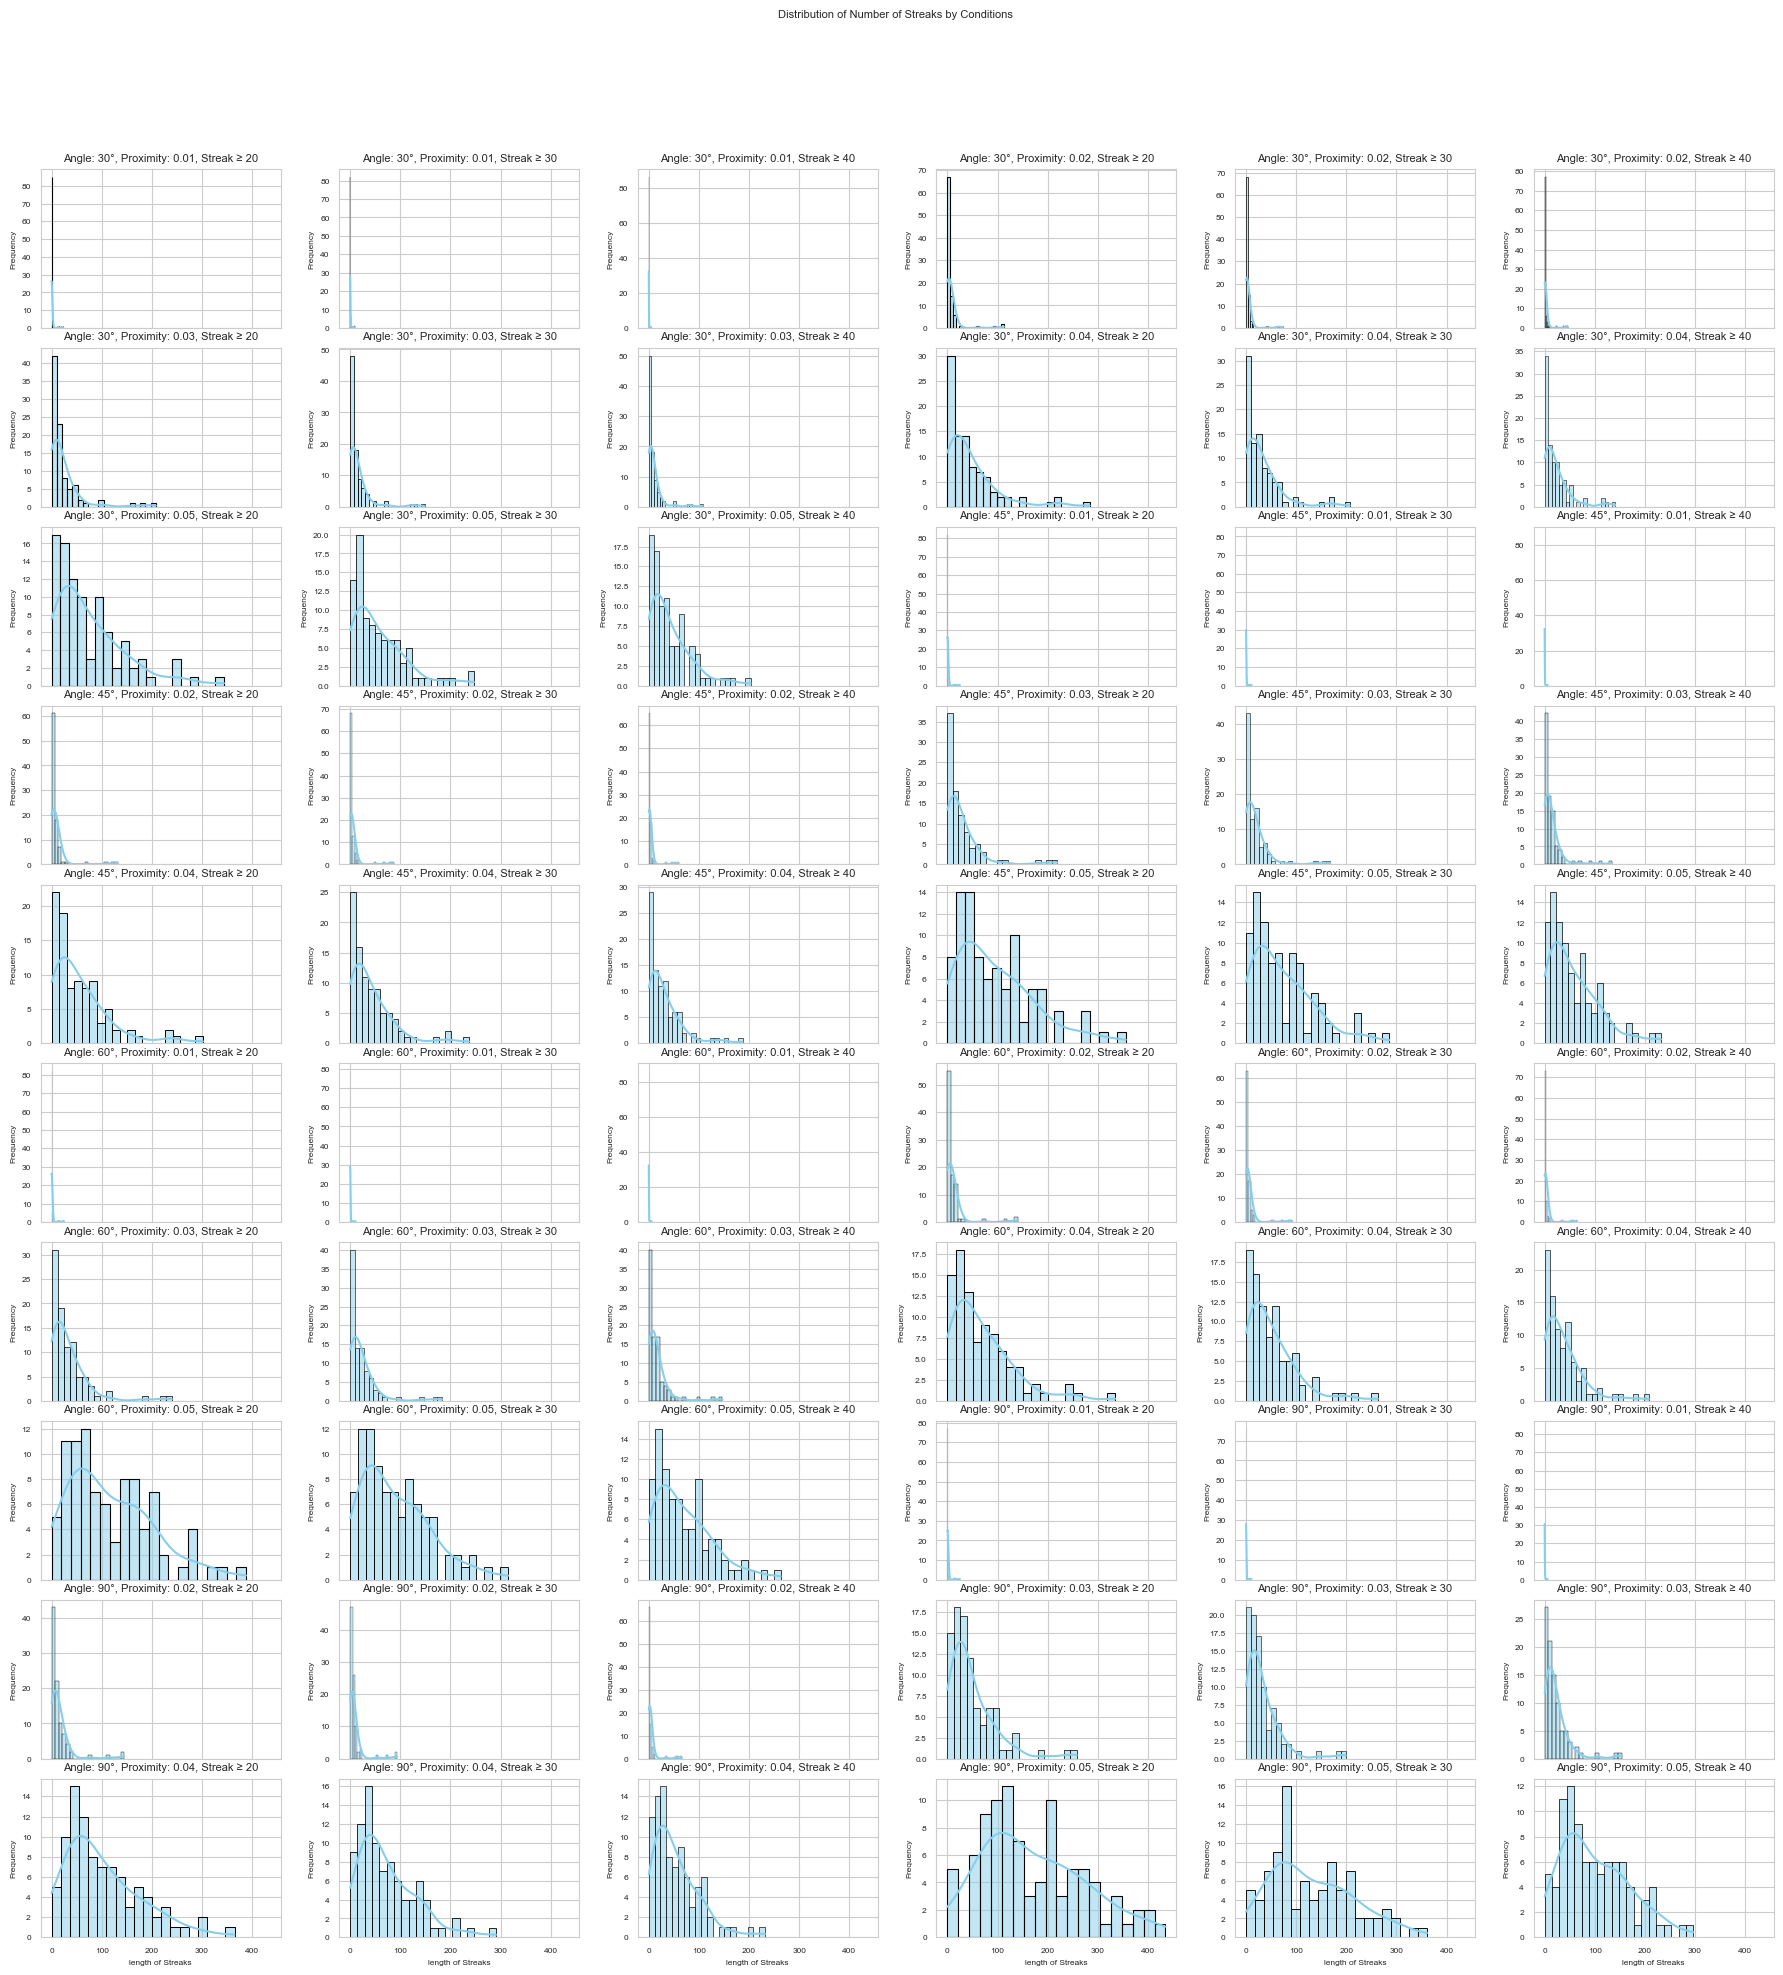

In [65]:
# Group the DataFrame by the combination of 'angle', 'proximity_threshold', and 'streak_length_threshold'
grouped = df.groupby(['angle', 'proximity_threshold', 'streak_length_threshold'])

# Calculate the number of subplots needed
num_subplots = len(grouped)
num_columns = 6  # You can choose how many columns of subplots you want
num_rows = (num_subplots + num_columns - 1) // num_columns  # Calculate rows needed

sns.set_style("whitegrid")

# Create a figure with the calculated number of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 2), sharex=True)
fig.tight_layout(pad=0.6)
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Number of Streaks by Conditions', fontsize=8)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each group and its corresponding data
for i, ((angle, proximity_threshold, streak_length_threshold), group) in enumerate(grouped):
    # Plot the histogram for the current group
    sns.histplot(group['number_of_streaks'], bins=20, edgecolor='black', color='skyblue', ax=axes[i], kde=True)
    axes[i].set_title(f'Angle: {angle}°, Proximity: {proximity_threshold}, Streak ≥ {streak_length_threshold}', fontsize=8)
    axes[i].set_xlabel('length of Streaks', fontsize=6)
    axes[i].set_ylabel('Frequency', fontsize=6)
    axes[i].tick_params(axis='both', which='major', labelsize=6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the histograms
plt.show()

In [8]:
# Function to convert the non-standard list string to an actual list of floats
def convert_to_list_of_floats(non_standard_list_str):
    # Remove the square brackets
    cleaned_str = non_standard_list_str.strip('[]')
    # Split the string by spaces and convert each to float
    return [float(num_str) for num_str in cleaned_str.split()]

# Apply the function to each element in the 'streak_lengths' column
df['streak_lengths'] = df['streak_lengths'].apply(convert_to_list_of_floats)

In [9]:
df

,file_path,angle,proximity_threshold,streak_length_threshold,streak_lengths,number_of_streaks
0,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,20,[],0
1,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,30,[],0
2,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.01,40,[],0
3,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.02,20,"[93.0, 25.0, 27.0, 22.0, 48.0, 21.0]",6
4,C:\PhD\experiments\fish_experiments\FishSizeKi...,30,0.02,30,"[93.0, 48.0]",2
...,...,...,...,...,...,...
5515,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.04,30,"[60.0, 38.0, 149.0, 117.0, 40.0, 36.0, 31.0, 3...",103
5516,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.04,40,"[60.0, 149.0, 117.0, 40.0, 48.0, 87.0, 86.0, 6...",80
5517,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.05,20,"[41.0, 37.0, 64.0, 60.0, 188.0, 164.0, 55.0, 5...",214
5518,C:\PhD\experiments\fish_experiments\FishSizeKi...,90,0.05,30,"[41.0, 37.0, 64.0, 60.0, 188.0, 164.0, 55.0, 5...",168


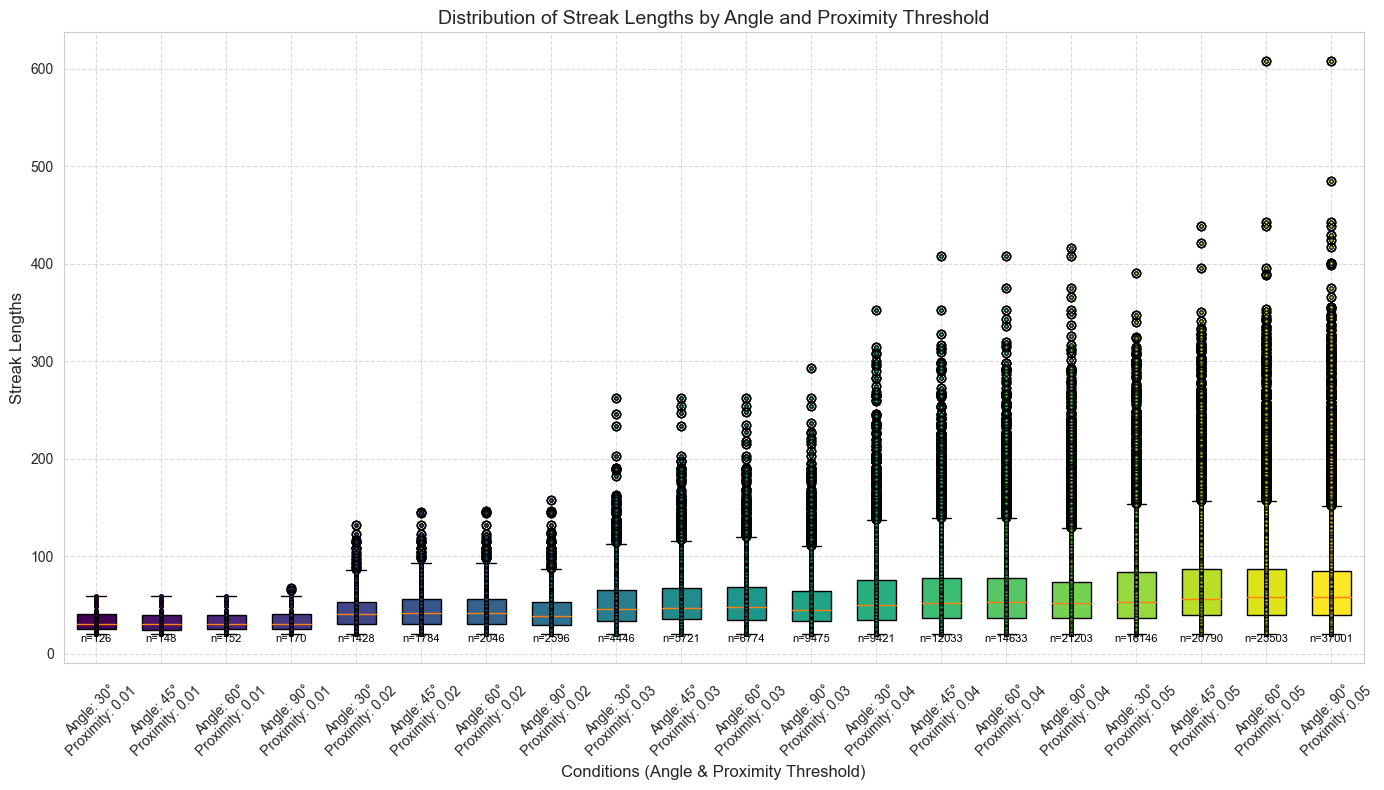

In [10]:
# Code for plotting
plt.figure(figsize=(14, 8))

# Prepare data for box plots
data_to_plot = []
labels = []
positions = []
colors = plt.cm.viridis(np.linspace(0, 1, len(proximity_thresholds) * len(angles)))

current_position = 1


for i, (proximity_threshold, angle) in enumerate([(pt, a) for pt in proximity_thresholds for a in angles]):
    filtered_df = df[(df['angle'] == angle) & (df['proximity_threshold'] == proximity_threshold)]
    all_lengths = [length for sublist in filtered_df['streak_lengths'] for length in sublist]
    
    if all_lengths:
        data_to_plot.append(all_lengths)
        labels.append(f'Angle: {angle}°\nProximity: {proximity_threshold}')
        positions.append(current_position)

        plt.scatter([current_position] * len(all_lengths), all_lengths, alpha=0.6, color=colors[i], edgecolor='black', s=6, zorder=2)
        current_position += 1

boxplots = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True, zorder=1)

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

for i, whisker in enumerate(boxplots['whiskers'][::2]):  # Use the bottom whiskers
    num_streaks = len(data_to_plot[i])
    x_position = positions[i]
    y_position = whisker.get_ydata()[1]  # Bottom of the whisker
    plt.text(x_position, y_position, f'n={num_streaks}', horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

plt.xlabel('Conditions (Angle & Proximity Threshold)', fontsize=12)
plt.ylabel('Streak Lengths', fontsize=12)
plt.title('Distribution of Streak Lengths by Angle and Proximity Threshold', fontsize=14)
plt.xticks(ticks=positions, labels=labels, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


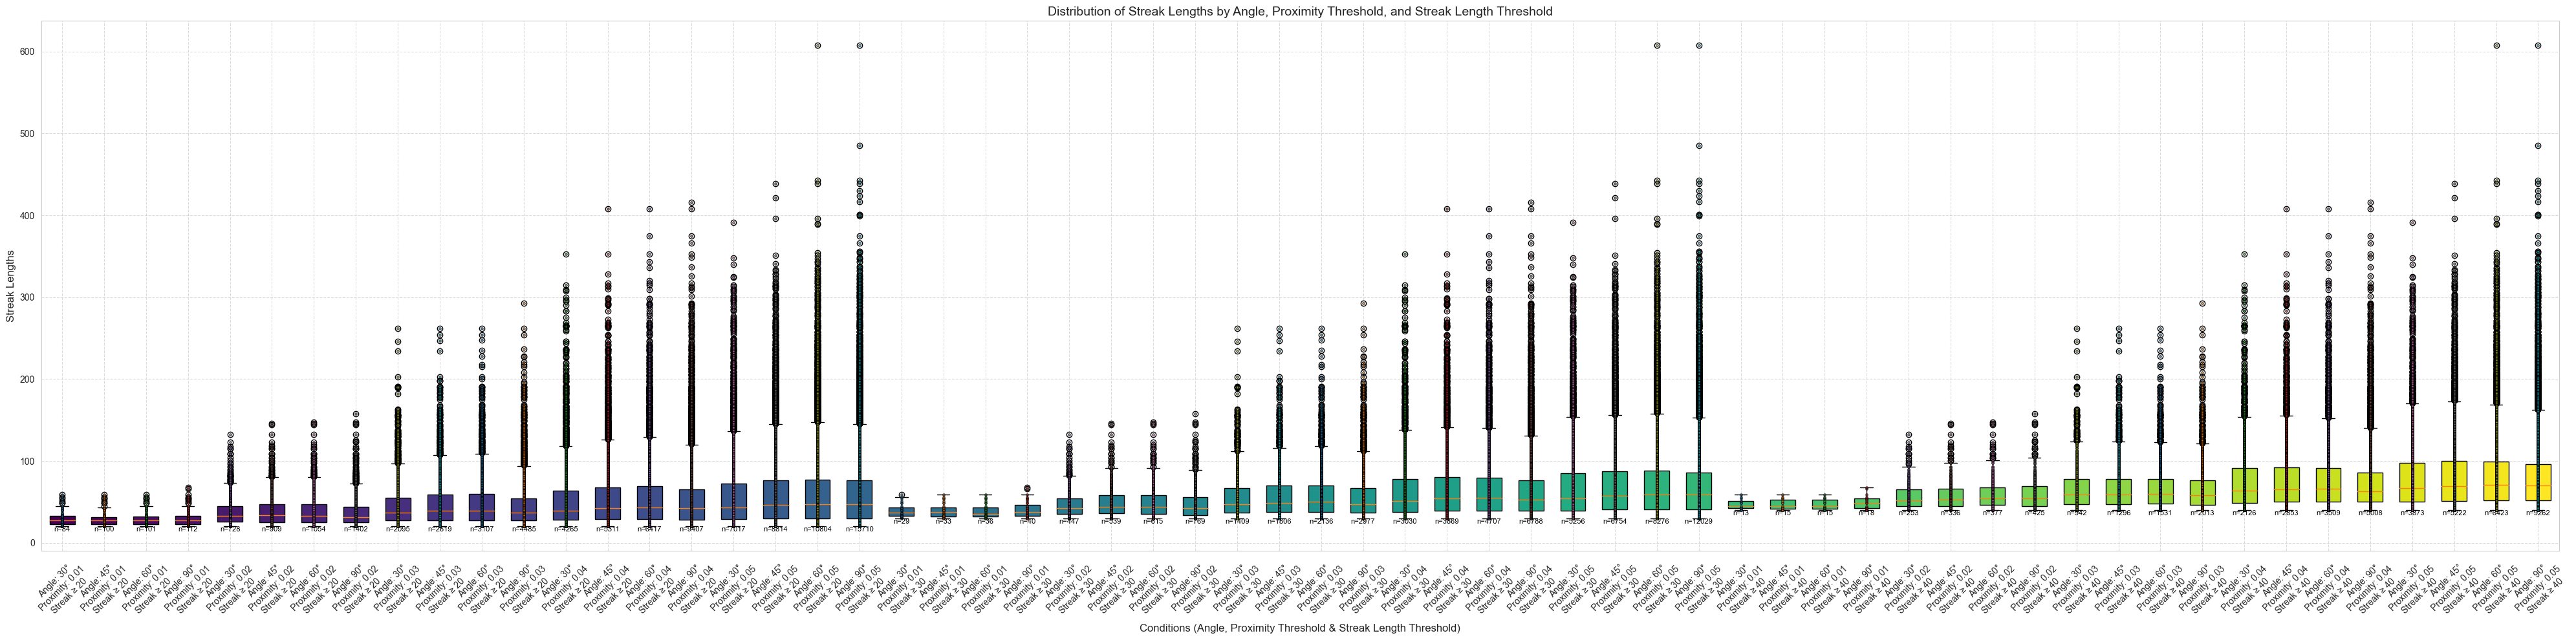

In [11]:
# plt.figure(figsize=(14, 8))

# Prepare data for box plots
data_to_plot = []
labels = []
positions = []
fig= plt.figure(figsize=(40, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(proximity_thresholds) * len(angles) * len(streak_length_thresholds)))

current_position = 1

for streak_length_threshold in streak_length_thresholds:
    for proximity_threshold in proximity_thresholds:
        for angle in angles:
            filtered_df = df[(df['angle'] == angle) &
                             (df['proximity_threshold'] == proximity_threshold) &
                             (df['streak_length_threshold'] == streak_length_threshold)]
            all_lengths = [length for sublist in filtered_df['streak_lengths'] for length in sublist]
            
            if all_lengths:
                data_to_plot.append(all_lengths)
                labels.append(f'Angle: {angle}°\nProximity: {proximity_threshold}\nStreak ≥ {streak_length_threshold}')
                positions.append(current_position)
                
                plt.scatter([current_position] * len(all_lengths), all_lengths, alpha=0.6, edgecolor='black', s=6, zorder=2)
                current_position += 1

boxplots = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True, zorder=1)

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

for i, whisker in enumerate(boxplots['whiskers'][::2]):  # Use the bottom whiskers
    num_streaks = len(data_to_plot[i])
    x_position = positions[i]
    y_position = whisker.get_ydata()[1]  # Bottom of the whisker
    plt.text(x_position, y_position, f'n={num_streaks}', horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

plt.xlabel('Conditions (Angle, Proximity Threshold & Streak Length Threshold)', fontsize=12)
plt.ylabel('Streak Lengths', fontsize=12)
plt.title('Distribution of Streak Lengths by Angle, Proximity Threshold, and Streak Length Threshold', fontsize=14)
plt.xticks(ticks=positions, labels=labels, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

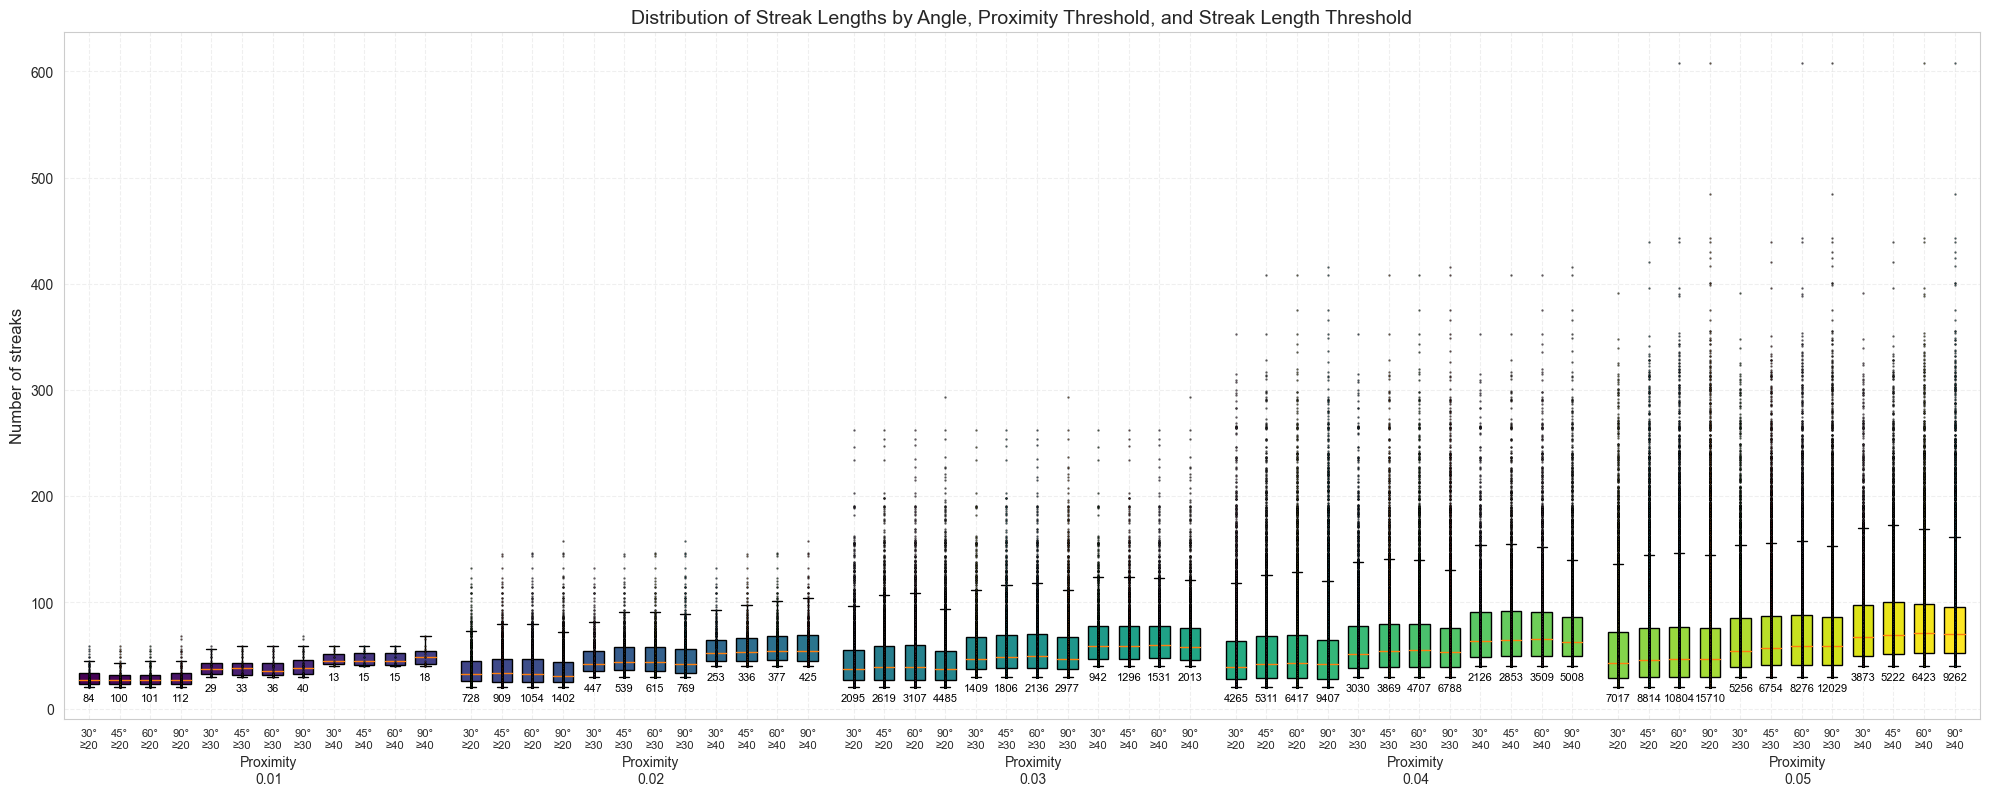

In [61]:
# Set figure size
plt.figure(figsize=(20, 8))

# Prepare data for box plots
data_to_plot = []
angle_streak_labels = []
proximity_labels = []
positions = []
colors = plt.cm.viridis(np.linspace(0, 1, len(proximity_thresholds) * len(angles) * len(streak_length_thresholds)))

current_position = 1
position_offset = 0.6
group_gap = 0.3  # Smaller gap between groups
proximity_label_positions = []

for proximity_threshold in proximity_thresholds:
    proximity_label_positions.append(current_position + (position_offset * len(streak_length_thresholds) * len(angles) / 2) - position_offset / 8)
    for streak_length_threshold in streak_length_thresholds:
        for angle in angles:
            filtered_df = df[(df['angle'] == angle) &
                             (df['proximity_threshold'] == proximity_threshold) &
                             (df['streak_length_threshold'] == streak_length_threshold)]
            all_lengths = [length for sublist in filtered_df['streak_lengths'] for length in sublist]
            
            if all_lengths:
                data_to_plot.append(all_lengths)
                angle_streak_labels.append(f'{angle}°\n≥{streak_length_threshold}')
                positions.append(current_position)
                
                plt.scatter([current_position] * len(all_lengths), all_lengths, alpha=0.6, edgecolor='black', s=0.5, zorder=2)
                current_position += position_offset

    current_position += group_gap  # Increase the position for the next proximity threshold group

# Create box plots
boxplots = plt.boxplot(data_to_plot, positions=positions, widths=0.4, patch_artist=True, zorder=1, showfliers=False)

# Set colors for each box
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

   
    # Add text for the number of streaks below each whisker
for i, whisker in enumerate(boxplots['whiskers'][::2]):  # Use the bottom whiskers
    num_streaks = len(data_to_plot[i])
    x_position = positions[i]
    y_position = whisker.get_ydata()[1]  # Bottom of the whisker
    # Move the text further down by subtracting a value from y_position
    plt.text(x_position, y_position - 6, f'{num_streaks}', horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

# Set labels and title
# plt.xlabel('Conditions', fontsize=12)
plt.ylabel('Number of streaks', fontsize=12)
plt.title('Distribution of Streak Lengths by Angle, Proximity Threshold, and Streak Length Threshold', fontsize=14)

# Set x-ticks for angle and streak length threshold labels
plt.xticks(ticks=positions, labels=angle_streak_labels, fontsize=8)

# Set x-ticks for proximity threshold labels
for pos, label in zip(proximity_label_positions, proximity_thresholds):
    plt.text(pos, -70, f'Proximity\n{label}', horizontalalignment='center', fontsize=10)  # Adjust y position as needed

plt.yticks(fontsize=10)

# Add grid
plt.grid(True, linestyle='--', alpha=0.3)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

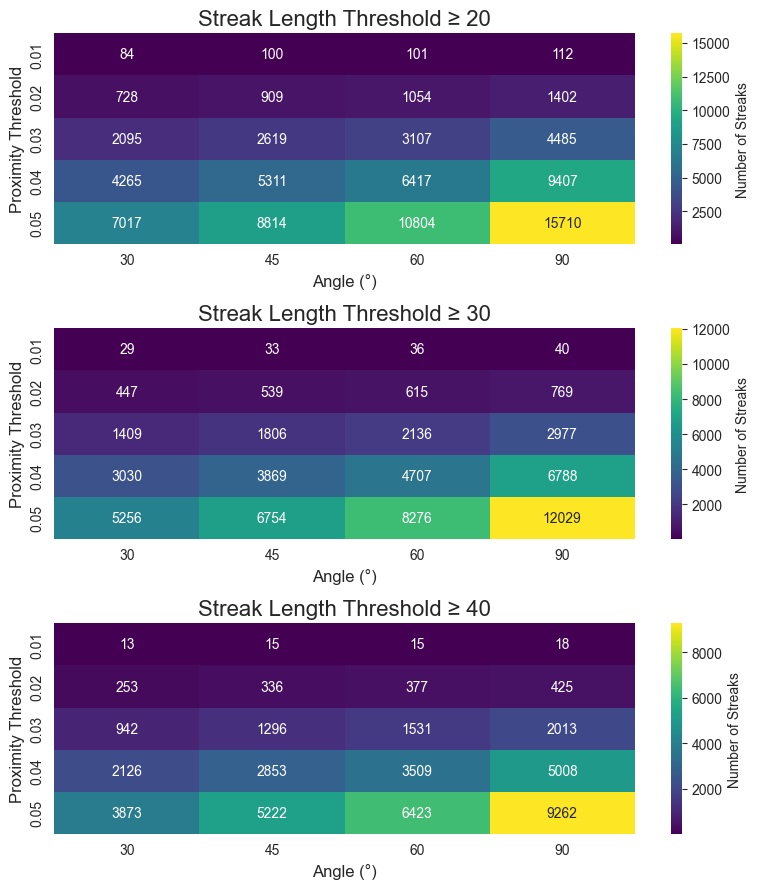

In [14]:
nrows = len(streak_length_thresholds)
ncols = 1

# Create a figure for the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 3 * nrows))

# Iterate over each streak_length_threshold to create a heatmap
for idx, streak_length_threshold in enumerate(streak_length_thresholds):
    # Create a DataFrame to store the number of streaks for each combination of angle and proximity_threshold
    heatmap_data = pd.DataFrame(index=proximity_thresholds, columns=angles)
    
    # Fill the DataFrame with the number of streaks for each combination
    for proximity_threshold in proximity_thresholds:
        for angle in angles:
            # Filter the DataFrame for the current combination of conditions
            filtered_df = df[(df['angle'] == angle) &
                             (df['proximity_threshold'] == proximity_threshold) &
                             (df['streak_length_threshold'] == streak_length_threshold)]
            # Get the number of streaks for the current combination
            num_streaks = filtered_df['number_of_streaks'].sum()
            heatmap_data.loc[proximity_threshold, angle] = num_streaks
    
    # Convert the heatmap data to numeric type
    heatmap_data = heatmap_data.astype(float)
    
    # Plot the heatmap in the corresponding subplot
    ax = axes[idx] if nrows > 1 else axes
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='viridis', cbar_kws={'label': 'Number of Streaks'}, ax=ax)
    ax.set_title(f'Streak Length Threshold ≥ {streak_length_threshold}', fontsize=16)
    ax.set_xlabel('Angle (°)', fontsize=12)
    ax.set_ylabel('Proximity Threshold', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

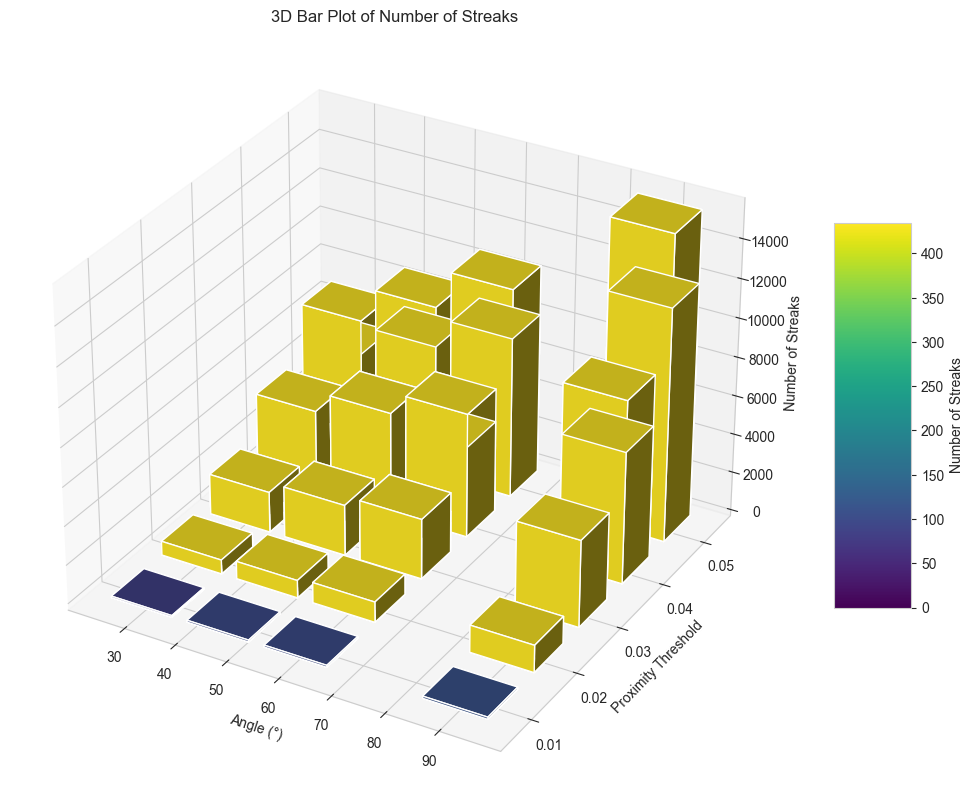

In [35]:
from mpl_toolkits.mplot3d import Axes3D
# Assuming df, proximity_thresholds, angles, and streak_length_thresholds are defined

# Create a colormap
cmap = plt.cm.get_cmap('viridis')

# Normalize the number_of_streaks for color mapping
norm = plt.Normalize(df['number_of_streaks'].min(), df['number_of_streaks'].max())

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# The size of each bar segment
dx = (max(angles) - min(angles)) / len(angles) * 0.8
dy = (max(proximity_thresholds) - min(proximity_thresholds)) / len(proximity_thresholds) * 0.8

# The starting points and heights for the bars
xpos = []
ypos = []
zpos = []
dz = []

# The colors of the bars (number of streaks)
color_data = []

# Populate the data lists
for angle in angles:
    for proximity_threshold in proximity_thresholds:
        for streak_length_threshold in streak_length_thresholds:
            filtered_df = df[(df['angle'] == angle) &
                             (df['proximity_threshold'] == proximity_threshold) &
                             (df['streak_length_threshold'] == streak_length_threshold)]
            num_streaks = filtered_df['number_of_streaks'].sum()
            xpos.append(angle)
            ypos.append(proximity_threshold)
            zpos.append(0)  # Bars start at z=0
            dz.append(num_streaks)  # The height of the bar is the number of streaks
            color_data.append(num_streaks)

# Convert positions to arrays and adjust positions
xpos = np.array(xpos) - dx/2  # Shift bars to the left by half their width
ypos = np.array(ypos) - dy/2  # Shift bars back by half their depth
zpos = np.array(zpos)
dz = np.array(dz)

# Create the bar plot
sc = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cmap(norm(color_data)))

# Color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Number of Streaks')

# Set labels
ax.set_xlabel('Angle (°)')
ax.set_ylabel('Proximity Threshold')
ax.set_zlabel('Number of Streaks')

# Set title
ax.set_title('3D Bar Plot of Number of Streaks')

plt.show()